# Class 7: More `pandas`, Visualizations, `xarray` and Modeling

## More pandas!

### Working with String DataFrames

Pandas' `Series` instances with a *dtype* of `object` or `string` expose a `str` attribute that enables vectorized string operations. These can come in tremendously handy, particularly when cleaning the data and performing aggregations on manually submitted fields.

```{margin}
For an in depth introduction to working with text data in `pandas`, see [the relevant section in the documentation site](https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html).
```

Let's imagine having the misfortune of reading some CSV data and finding the following headers:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

messy_strings = [
    'Id___name', 'AGE', ' DomHand ', np.nan, 'qid    score1', 'score2', 3,
    ' COLOR_ SHAPe   _size', 'origin_residence immigration'
]
s = pd.Series(messy_strings, dtype="string", name="Messy Strings")
s

0                       Id___name
1                             AGE
2                        DomHand 
3                            <NA>
4                   qid    score1
5                          score2
6                               3
7            COLOR_ SHAPe   _size
8    origin_residence immigration
Name: Messy Strings, dtype: string

To try and parse something more reasonable, we might first want to remove all unnecessary whitespace and underscores. One way to achieve that would be:

In [3]:
s_1 = s.str.strip().str.replace("[_\s]+", " ", regex=True).str.lower()
s_1

0                         id name
1                             age
2                         domhand
3                            <NA>
4                      qid score1
5                          score2
6                               3
7                color shape size
8    origin residence immigration
Name: Messy Strings, dtype: string

Let's break this down:
* `strip()` removed all whitespace from the beginning and end of the string.
* We used a [regular expression](https://en.wikipedia.org/wiki/Regular_expression) to replace all one or more (`+`) occurrences of whitespace (`\s`) and underscores with single spaces.
* We converted all characters to lowercase.

Next, we'll `split()` strings separated by whitespace and extract an array of the values:

In [4]:
s_2 = s_1.str.split(expand=True)
print(f"DataFrame:\n{s_2}")

s_3 = s_2.to_numpy().flatten()
print(f"\nArray:\n{s_3}")

DataFrame:
         0          1            2
0       id       name         <NA>
1      age       <NA>         <NA>
2  domhand       <NA>         <NA>
3     <NA>       <NA>         <NA>
4      qid     score1         <NA>
5   score2       <NA>         <NA>
6        3       <NA>         <NA>
7    color      shape         size
8   origin  residence  immigration

Array:
['id' 'name' <NA> 'age' <NA> <NA> 'domhand' <NA> <NA> <NA> <NA> <NA> 'qid'
 'score1' <NA> 'score2' <NA> <NA> '3' <NA> <NA> 'color' 'shape' 'size'
 'origin' 'residence' 'immigration']


Finally, we can get rid of the \<NA\> values:

In [5]:
column_names = s_3[~pd.isnull(s_3)]
column_names

array(['id', 'name', 'age', 'domhand', 'qid', 'score1', 'score2', '3',
       'color', 'shape', 'size', 'origin', 'residence', 'immigration'],
      dtype=object)

`````{admonition} DataFrame String Operations Exercise
* Generate a 1000x1 shaped`pd.DataFrame` filled with 3-letter strings. Use the `string` module's `ascii_lowercase` attribute and numpy's `random` module.

````{dropdown} Solution
```python
import string
import numpy as np
import pandas as pd

letters = list(string.ascii_lowercase)
n_strings = 1000
string_length = 3 
string_generator = ("".join(np.random.choice(letters, string_length))
                    for _ in range(n_strings))
df = pd.DataFrame(string_generator, columns=["Letters"])
```
````

* Add a column indicating if the string in this row has a `z` in its 2nd character.

````{dropdown} Solution
```python
target_char = "z"
target_index = 1
df["z!"] = df["Letters"].str.find(target_char) == target_index
```
````

* Add a third column containing the capitalized and reversed versions of the original strings.

````{dropdown} Solution
```python
df["REVERSED"] = df["Letters"].str.upper().apply(lambda s: s[::-1])
```
````
`````


### Concatenation and Merging

Similarly to NumPy arrays, `Series` and `DataFrame` objects can be concatenated as well. However, having indices can often make this operation somewhat less trivial. 

```{margin}
For an in depth introduction to merging, joining, concatentation, and comparison in `pandas`, see [the relevant section in the documentation site](https://pandas.pydata.org/pandas-docs/stable/merging.html).
```

In [6]:
ser1 = pd.Series(['a', 'b', 'c'], index=[1, 2, 3])
ser2 = pd.Series(['d', 'e', 'f'], index=[4, 5, 6])
pd.concat([ser1, ser2])  # row-wise (axis=0) by default

1    a
2    b
3    c
4    d
5    e
6    f
dtype: object

Let's do the same with dataframes:

In [7]:
df1 = pd.DataFrame([['a', 'A'], ['b', 'B']], columns=['let', 'LET'], index=[0, 1])
df2 = pd.DataFrame([['c', 'C'], ['d', 'D']], columns=['let', 'LET'], index=[2, 3])
pd.concat([df1, df2])  # again, along the first axis

,let,LET
0,a,A
1,b,B
2,c,C
3,d,D


This time, let's complicate things a bit, and introduce different column names:

In [8]:
df1 = pd.DataFrame([['a', 'A'], ['b', 'B']], columns=['let1', 'LET1'], index=[0, 1])
df2 = pd.DataFrame([['c', 'C'], ['d', 'D']], columns=['let2', 'LET2'], index=[2, 3])
pd.concat([df1, df2])  # pandas can't make the column index compatible, so it resorts to columnar concat

,let1,LET1,let2,LET2
0,a,A,NaN,NaN
1,b,B,NaN,NaN
2,NaN,NaN,c,C
3,NaN,NaN,d,D


The same result would be achieved by:

In [9]:
pd.concat([df1, df2], axis=1)

,let1,LET1,let2,LET2
0,a,A,NaN,NaN
1,b,B,NaN,NaN
2,NaN,NaN,c,C
3,NaN,NaN,d,D


But what happens if introduce overlapping indices?

In [10]:
df1 = pd.DataFrame([['a', 'A'], ['b', 'B']], columns=['let', 'LET'], index=[0, 1])
df2 = pd.DataFrame([['c', 'C'], ['d', 'D']], columns=['let', 'LET'], index=[0, 2])
pd.concat([df1, df2])

,let,LET
0,a,A
1,b,B
0,c,C
2,d,D


Nothing, really! While not recommended in practice, pandas won't judge you. 

If, however, we wish to keep the integrity of the indices, we can use the `verify_integrity` keyword:

In [11]:
df1 = pd.DataFrame([['a', 'A'], ['b', 'B']], columns=['let', 'LET'], index=[0, 1])
df2 = pd.DataFrame([['c', 'C'], ['d', 'D']], columns=['let', 'LET'], index=[0, 2])
pd.concat([df1, df2], verify_integrity=True)

ValueError: Indexes have overlapping values: Index([0], dtype='int64')

If we don't care about the indices, we can just ignore them:

In [12]:
pd.concat([df1, df2], ignore_index=True)  # resets the index

,let,LET
0,a,A
1,b,B
2,c,C
3,d,D


We can also create a new `MultiIndex` if that happens to makes more sense:

In [13]:
pd.concat([df1, df2], keys=['df1', 'df2'])  # "remembers" the origin of the data, super useful!

let LET
df1 0   a   A
    1   b   B
df2 0   c   C
    2   d   D

A common real world example of concatenation happens when joining two datasets sampled at different times. For example, if we conducted in day 1 measurements at times 8:00, 10:00, 14:00 and 16:00, but during day 2 we were a bit dizzy, and conducted the measurements at 8:00, 10:00, 13:00 and 16:30. On top of that, we recorded another parameter that we forget to measure at day 1.

The default concatenation behavior of pandas keeps all the data. In database terms (SQL people rejoice!) it's called an "outer join":

In [14]:
# Prepare mock data
day_1_times = pd.to_datetime(['08:00', '10:00', '14:00', '16:00'],
                             format='%H:%M').time
day_2_times = pd.to_datetime(['08:00', '10:00', '13:00', '16:30'],
                             format='%H:%M').time

day_1_data = {
    "temperature": [36.6, 36.7, 37.0, 36.8],
    "humidity": [30., 31., 30.4, 30.4]
}
day_2_data = {
    "temperature": [35.9, 36.1, 36.5, 36.2],
    "humidity": [32.2, 34.2, 30.9, 32.6],
    "light": [200, 130, 240, 210]
}

df_1 = pd.DataFrame(day_1_data, index=day_1_times)
df_2 = pd.DataFrame(day_2_data, index=day_2_times)

df_1

,temperature,humidity
08:00:00,36.6,30.0
10:00:00,36.7,31.0
14:00:00,37.0,30.4
16:00:00,36.8,30.4


```{note}
Note how [`pd.to_datetime()`](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html) returns a [`DatetimeIndex`](https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html) object which exposes a `time` property, allowing us to easily remove the "date" part of the returned "datetime", considering it is not represented in our mock data.
```

In [15]:
df_2

,temperature,humidity,light
08:00:00,35.9,32.2,200
10:00:00,36.1,34.2,130
13:00:00,36.5,30.9,240
16:30:00,36.2,32.6,210


In [16]:
# Outer join
pd.concat([df_1, df_2], join='outer')  # outer join is the default behavior  

,temperature,humidity,light
08:00:00,36.6,30.0,NaN
10:00:00,36.7,31.0,NaN
14:00:00,37.0,30.4,NaN
16:00:00,36.8,30.4,NaN
08:00:00,35.9,32.2,200.0
10:00:00,36.1,34.2,130.0
13:00:00,36.5,30.9,240.0
16:30:00,36.2,32.6,210.0


To take the intersection of the columns we have to use inner join. The intersection is all the columns that are common in all datasets.

In [17]:
# Inner join - the excess data column was dropped (index is still not unique)
pd.concat([df_1, df_2], join='inner')

,temperature,humidity
08:00:00,36.6,30.0
10:00:00,36.7,31.0
14:00:00,37.0,30.4
16:00:00,36.8,30.4
08:00:00,35.9,32.2
10:00:00,36.1,34.2
13:00:00,36.5,30.9
16:30:00,36.2,32.6


One can also specify the exact columns that should be the result of the join operation using the `columns` keyword. All in all, this basic functionality is easy to understand and allows for high flexibility.

Finally, joining on the columns will require the indices to be unique:

In [18]:
pd.concat([df_1, df_2], join='inner', axis='columns')

,temperature,humidity,temperature,humidity,light
08:00:00,36.6,30.0,35.9,32.2,200
10:00:00,36.7,31.0,36.1,34.2,130


This doesn't look so good. The columns are a mess and we're barely left with any data.

Our best option using `pd.concat()` might be something like:

In [19]:
df_concat = pd.concat([df_1, df_2], keys=["Day 1", "Day 2"])
df_concat

temperature  humidity  light
Day 1 08:00:00         36.6      30.0    NaN
      10:00:00         36.7      31.0    NaN
      14:00:00         37.0      30.4    NaN
      16:00:00         36.8      30.4    NaN
Day 2 08:00:00         35.9      32.2  200.0
      10:00:00         36.1      34.2  130.0
      13:00:00         36.5      30.9  240.0
      16:30:00         36.2      32.6  210.0

Or maybe an unstacked version:

In [20]:
df_concat.unstack(0)

temperature       humidity       light       
               Day 1 Day 2    Day 1 Day 2 Day 1  Day 2
08:00:00        36.6  35.9     30.0  32.2   NaN  200.0
10:00:00        36.7  36.1     31.0  34.2   NaN  130.0
13:00:00         NaN  36.5      NaN  30.9   NaN  240.0
14:00:00        37.0   NaN     30.4   NaN   NaN    NaN
16:00:00        36.8   NaN     30.4   NaN   NaN    NaN
16:30:00         NaN  36.2      NaN  32.6   NaN  210.0

We could also use [`pd.merge()`](https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.merge.html):

In [21]:
pd.merge(df_1,
         df_2,
         how="outer",           # Keep all indices (rather than just the intersection)
         left_index=True,       # Use left index
         right_index=True,      # Use right index
         suffixes=("_1", "_2")) # Suffixes to use for overlapping columns

,temperature_1,humidity_1,temperature_2,humidity_2,light
08:00:00,36.6,30.0,35.9,32.2,200.0
10:00:00,36.7,31.0,36.1,34.2,130.0
13:00:00,NaN,NaN,36.5,30.9,240.0
14:00:00,37.0,30.4,NaN,NaN,NaN
16:00:00,36.8,30.4,NaN,NaN,NaN
16:30:00,NaN,NaN,36.2,32.6,210.0


The dataframe's [`merge()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) method also enables easily combining columns from a different (but similarly indexed) dataframe:

In [22]:
mouse_id = [511, 512, 513, 514]
meas1 = [67, 66, 89, 92]
meas2 = [45, 45, 65, 61]

data_1 = {"ID": [500, 501, 502, 503], "Blood Volume": [100, 102, 99, 101]}
data_2 = {"ID": [500, 501, 502, 503], "Monocytes": [20, 19, 25, 21]}

df_1 = pd.DataFrame(data_1)
df_2 = pd.DataFrame(data_2)
df_1

,ID,Blood Volume
0,500,100
1,501,102
2,502,99
3,503,101


In [23]:
df_1.merge(df_2)  # merge identified that the only "key" connecting the two tables was the 'id' key

,ID,Blood Volume,Monocytes
0,500,100,20
1,501,102,19
2,502,99,25
3,503,101,21


Database-like operations are a very broad topic with advanced implementations in pandas.

`````{admonition} Concatenation and Merging Exercise
* Create three dataframes with random values and shapes of (10, 2), (10, 1), (15, 3). Their index should be simple ordinal integers, and their column names should be different.

````{dropdown} Solution
```python
df_1 = pd.DataFrame(np.random.random((10, 2)), columns=['a', 'b'])
df_2 = pd.DataFrame(np.random.random((10, 1)), columns=['c'])
df_3 = pd.DataFrame(np.random.random((15, 3)), columns=['d', 'e', 'f'])
```
````

* Concatenate these dataframes over the second axis using `pd.concat()`.

````{dropdown} Solution
```python
pd.concat([df_1, df_2, df_3], axis=1)
```
````

* Concatenate these dataframes over the second axis using `pd.merge()`.

````{dropdown} Solution
```python
merge_kwargs = {"how": "outer", "left_index": True, "right_index": True}
pd.merge(pd.merge(df_1, df_2, **merge_kwargs), df_3, **merge_kwargs)
```
````
`````

### Grouping

Yet another SQL-like feature that pandas posses is the group-by operation, sometimes known as "split-apply-combine".

In [24]:
# Mock data
subject = range(100, 200)
alive = np.random.choice([True, False], 100)
placebo = np.random.choice([True, False], 100)
measurement_1 = np.random.random(100)
measurement_2 = np.random.random(100)
data = {
    "Subject ID": subject,
    "Alive": alive,
    "Placebo": placebo,
    "Measurement 1": measurement_1,
    "Measurement 2": measurement_2
}
df = pd.DataFrame(data).set_index("Subject ID")
df

,Alive,Placebo,Measurement 1,Measurement 2
Subject ID,,,,
100,False,True,0.693578,0.109215
101,True,True,0.536397,0.662925
102,False,False,0.224192,0.007915
103,True,False,0.541027,0.973593
104,False,False,0.497384,0.268210
...,...,...,...,...
195,True,True,0.001750,0.103425
196,True,False,0.339509,0.312900
197,False,False,0.825436,0.575736


The most sensible thing to do is to group by either the "Alive" or the "Placebo" columns (or both). This is the "split" part.

In [25]:
grouped = df.groupby('Alive')
grouped  # DataFrameGroupBy object - intermediate object ready to be evaluated

This intermediate object is an internal pandas representation which should allow it to run very fast computation the moment we want to actually _know_ something about these groups. Assuming we want the mean of `Measurement 1`, as long as we won't specifically write `grouped.mean()` pandas will do very little in terms of actual computation. It's called "lazy evaluation".

The intermediate object has some useful attributes:

In [26]:
grouped.groups

{False: [100, 102, 104, 105, 107, 109, 110, 111, 112, 113, 114, 115, 116, 119, 123, 124, 125, 126, 130, 131, 135, 139, 141, 142, 143, 144, 146, 151, 152, 153, 155, 156, 157, 158, 165, 166, 168, 169, 170, 171, 173, 174, 179, 184, 187, 191, 192, 193, 197, 198], True: [101, 103, 106, 108, 117, 118, 120, 121, 122, 127, 128, 129, 132, 133, 134, 136, 137, 138, 140, 145, 147, 148, 149, 150, 154, 159, 160, 161, 162, 163, 164, 167, 172, 175, 176, 177, 178, 180, 181, 182, 183, 185, 186, 188, 189, 190, 194, 195, 196, 199]}

In [27]:
len(grouped)  # True and False

2

If we wish to run some actual processing, we have to use an aggregation function:

In [28]:
grouped.sum()

,Placebo,Measurement 1,Measurement 2
Alive,,,
False,19,26.355717,24.211523
True,29,23.786082,28.607547


In [29]:
grouped.mean()

,Placebo,Measurement 1,Measurement 2
Alive,,,
False,0.38,0.527114,0.484230
True,0.58,0.475722,0.572151


In [30]:
grouped.size()

Alive
False    50
True     50
dtype: int64

If we just wish to see one of the groups, we can use `get_group()`:

In [31]:
grouped.get_group(True).head()

,Alive,Placebo,Measurement 1,Measurement 2
Subject ID,,,,
101,True,True,0.536397,0.662925
103,True,False,0.541027,0.973593
106,True,True,0.072025,0.743331
108,True,False,0.982296,0.969610
117,True,False,0.641704,0.475893


We can also call several functions at once using the `.agg` attribute:

In [32]:
grouped.agg([np.mean, np.std]).drop("Placebo", axis=1)

/tmp/ipykernel_234405/773109026.py:1: FutureWarning: The provided callable <function mean at 0x78ae7c5f6840> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grouped.agg([np.mean, np.std]).drop("Placebo", axis=1)
/tmp/ipykernel_234405/773109026.py:1: FutureWarning: The provided callable <function std at 0x78ae7c5f6980> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  grouped.agg([np.mean, np.std]).drop("Placebo", axis=1)


Measurement 1           Measurement 2          
               mean       std          mean       std
Alive                                                
False      0.527114  0.263592      0.484230  0.323475
True       0.475722  0.279444      0.572151  0.301904

Grouping by multiple columns:

In [33]:
grouped2 = df.groupby(['Alive', 'Placebo'])
grouped2

In [34]:
grouped2.agg([np.sum, np.var])

/tmp/ipykernel_234405/557621468.py:1: FutureWarning: The provided callable <function sum at 0x78ae7c5f5440> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  grouped2.agg([np.sum, np.var])
/tmp/ipykernel_234405/557621468.py:1: FutureWarning: The provided callable <function var at 0x78ae7c5f6ac0> is currently using SeriesGroupBy.var. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "var" instead.
  grouped2.agg([np.sum, np.var])


Measurement 1           Measurement 2          
                        sum       var           sum       var
Alive Placebo                                                
False False       14.460490  0.063328     15.173510  0.096224
      True        11.895227  0.066926      9.038013  0.124345
True  False       10.230053  0.079387     12.305695  0.113690
      True        13.556029  0.079782     16.301852  0.078051

`groupby()` offers many more features, available [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html).

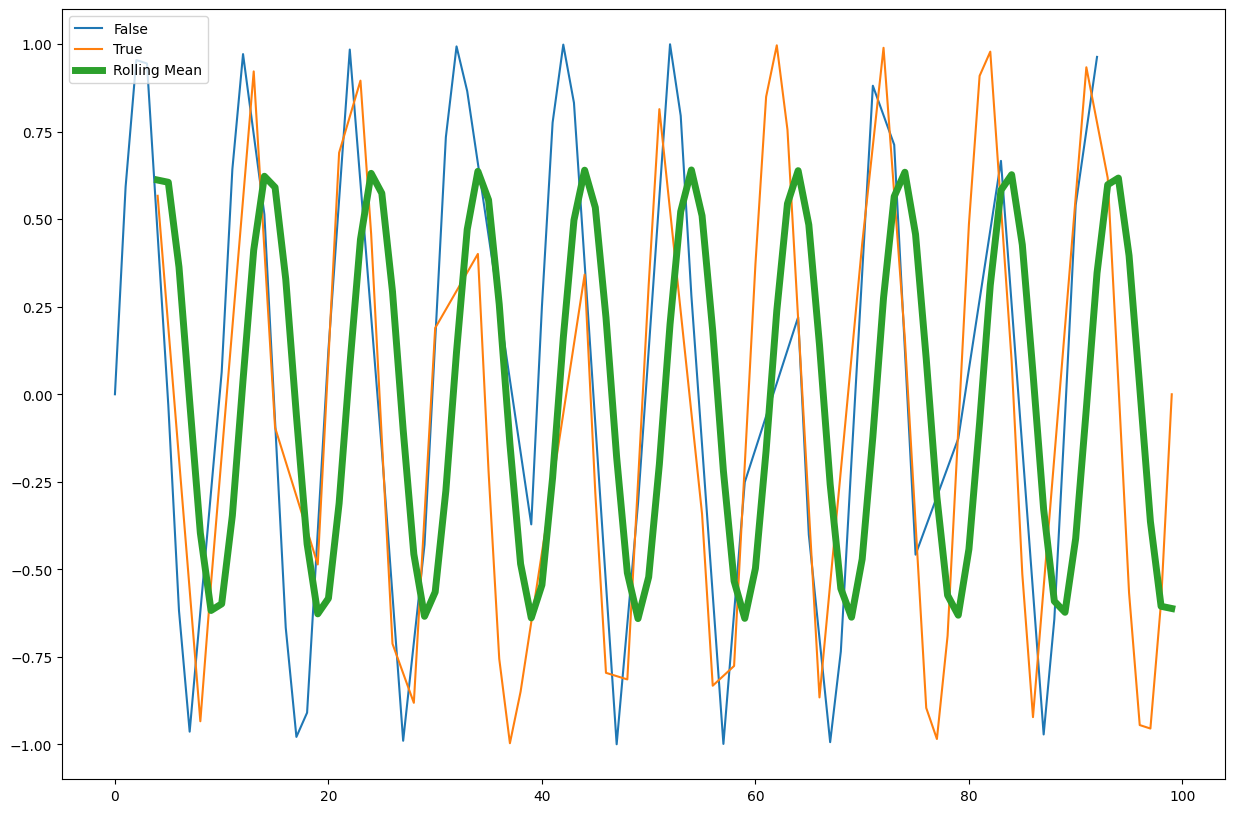

In [35]:
import matplotlib.pyplot as plt
from myst_nb import glue

fig, ax = plt.subplots(figsize=(15, 10))

boolean_groups = np.array([False, True])
n_subjects = 100
stop = 20 * np.pi
group_choice = np.random.choice(boolean_groups, n_subjects)
values = np.sin(np.linspace(start=0, stop=stop, num=n_subjects))
df = pd.DataFrame({'group': group_choice, 'value': values})
grouped = df.groupby("group")
grouped_plot = grouped.value.plot(ax=ax)

glue("grouped_plot", fig, display=False)

window_size = 5
rolling_mean = df.value.rolling(window=window_size).mean()
final_plot = rolling_mean.plot(ax=ax, label="Rolling Mean", linewidth=5)
ax.legend(loc="upper left")

glue("final_plot", fig, display=False)

`````{admonition} Grouping Exercise
* Create a dataframe with two columns, 10,000 entries in length. The first should be a random boolean column, and the second should be a sine wave from 0 to 20$\pi$. This simulates measuring a parameter from two distinct groups.

````{dropdown} Solution
```python
boolean_groups = np.array([False, True])
n_subjects = 100
stop = 20 * np.pi
group_choice = np.random.choice(boolean_groups, n_subjects)
values = np.sin(np.linspace(start=0, stop=stop, num=n_subjects))
df = pd.DataFrame({'group': group_choice, 'value': values})
```
````

* Group the dataframe by your boolean column, creating a `GroupBy` object.

````{dropdown} Solution
```python
grouped = df.groupby("group")
```
````

* Plot the values of the grouped dataframe.

````{dropdown} Solution
```python
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 10))
grouped_plot = grouped.value.plot(ax=ax)
```
```{glue:figure} grouped_plot
    :figwidth: 500px
```
````

* Use the [`rolling()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html) method to create a rolling average window of length 5 and overlay the result.

````{dropdown} Solution
```python
window_size = 5
rolling_mean = df.value.rolling(window=window_size).mean()
rolling_mean.plot(ax=ax, label="Rolling Mean", linewidth=5)
ax.legend(loc="upper left")
```
```{glue:figure} final_plot
    :figwidth: 500px
```
````
`````

### Other Pandas Features

Pandas has a __TON__ of features and small implementation details that are there to make your life simpler. Features like `IntervalIndex` to index the data between two numbers instead of having a single label, for example, are very nice and ergonomic if you need them. Sparse DataFrames are also included, as well as many other computational tools, serialization capabilities, and more. If you need it - there's a good chance it already exists as a method in the pandas jungle.